In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import scipy
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import optuna
from sklearn.impute import SimpleImputer

pd.set_option("display.max_columns", None)

## TRAIN

In [2]:
# or data/train_df.csv
df_train = pd.read_csv("/kaggle/input/privat-bank-ds/train_df.csv", sep="\t")

### Preprocesing functions

In [3]:
def del_same_cat_features(df):
    """
    Removes categorical features that have repetitive values in the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing categorical features.

    Returns:
        cleaned_df (pandas.DataFrame): The DataFrame with repetitive categorical features removed.
        repetitive_cols (list): A list of the removed repetitive categorical feature names.
    """
    repetitive_cols = []
    categorical_features = [column for column in df.columns if column.startswith('cat_')]
    for column in df[categorical_features]:
        value_counts = df[column].value_counts()
        if value_counts.iloc[0] > len(df) * 0.9:  # Threshold for repetition, if more than 90% of the values are the same
            repetitive_cols.append(column)

    cleaned_df = df.drop(repetitive_cols, axis=1)
    print(len(repetitive_cols))
    return cleaned_df, repetitive_cols

In [4]:
def del_sparce_num_features(df):
    """
    Removes sparse numeric features from the DataFrame based on the variance threshold.

    Args:
        df (pandas.DataFrame): The DataFrame containing numeric features.

    Returns:
        cleaned_df (pandas.DataFrame): The DataFrame with sparse numeric features removed.
        sparse_columns (list): A list of the removed sparse numeric feature names.
    """
    numeric_features = [column for column in df.columns if column.startswith('num_')]
    numerical_stats = df[numeric_features].describe()

    variance_threshold = 0.01  # Columns with variance below this threshold will be considered sparse

    sparse_numeric_features = [col for col in numeric_features if numerical_stats.loc['std', col] < variance_threshold]

    sparse_columns = sparse_numeric_features

    df = df.drop(columns=sparse_columns)
    return df, sparse_columns


In [5]:
def del_nans(df):
    """
    Deletes columns with NaN values from the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to remove columns with NaN values from.

    Returns:
        cleaned_df (pandas.DataFrame): The DataFrame with columns containing NaN values removed.
        nan_columns (list): A list of the removed column names containing NaN values.
    """
    columns_with_all_nan = df.columns[df.isna().all()]
    df = df.drop(columns=columns_with_all_nan)
    df = df.drop(columns=["Unnamed: 0", "id"])
    print(columns_with_all_nan)
    return df, columns_with_all_nan
          


In [6]:
def del_cols_missing(df):
    """
    Deletes columns with a high percentage of missing values from the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to remove columns with missing values from.

    Returns:
        cleaned_df (pandas.DataFrame): The DataFrame with columns containing missing values removed.
        missing_columns (list): A list of the removed column names containing missing values.
    """
    # Calculate the percentage of missing values for each column
    missing_percentages = df.isnull().sum() / len(df) * 100

    # Sort
    missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

#     # Plot a bar chart to visualize the missingness distribution
#     plt.figure(figsize=(12, 6))
#     plt.bar(missing_percentages_sorted.index, missing_percentages_sorted)
#     plt.xticks(rotation=90)
#     plt.xlabel('Columns')
#     plt.ylabel('Missing Percentage')
#     plt.title('Percentage of Missing Values in Each Column')
#     plt.show()

    print((missing_percentages>50).sum())
    delete_cols = missing_percentages[missing_percentages>50].index
    df = df.drop(columns=delete_cols)
    return df, delete_cols

In [7]:
def impute(df):
    """
    Imputes missing values in the DataFrame using the mean strategy.

    Args:
        df (pandas.DataFrame): The DataFrame to impute missing values in.

    Returns:
        imputed_df (pandas.DataFrame): The DataFrame with missing values imputed.
    """
    imputer = SimpleImputer(strategy='mean')

    imputer.fit(df)

    df = pd.DataFrame(imputer.transform(df), columns=df.columns)
    print(df.isna().sum().sum())
    return df

In [8]:
def del_outliers(df):
    """
    Removes outliers from the DataFrame using the z-score method.

    Args:
        df (pandas.DataFrame): The DataFrame to remove outliers from.

    Returns:
        cleaned_df (pandas.DataFrame): The DataFrame with outliers removed.
    """
    def remove_outliers_zscore(df, threshold=3):
        z_scores = np.abs(stats.zscore(df))
        outlier_indices = np.where(z_scores > threshold)
        cleaned_df = df.drop(outlier_indices[0])
        return cleaned_df


    # Detect outliers
    outlier_indices = remove_outliers_zscore(df)

    # Remove outliers
    df_filtered = df.drop(outlier_indices.index)
    return df_filtered


In [9]:
def del_skew(df):
    """
    Applies log transformation to skewed numeric columns in the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to remove skewness from.

    Returns:
        transformed_df (pandas.DataFrame): The DataFrame with log-transformed skewed numeric columns.
    """
    numeric_col_name = [column for column in df.columns if column.startswith('num_')]
    skew_df = pd.DataFrame(numeric_col_name, columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x>=0.5 else False)
    #     skew_df
    # 
    skew_df["Skewed"].value_counts()
    
    # Apply for skewed columns log transform
    for colunm in skew_df.query('Skewed == True')['Feature'].values:
        negative_or_zero_mask = (df[colunm] <= 0)
        df.loc[negative_or_zero_mask, colunm] = 0
        df[colunm] = np.log1p(df[colunm])

    print(df.isna().sum().sum())
    return df

In [10]:
def replace_zeros(df):
    """
    Replaces zeros in numeric columns of the DataFrame with the mode value of non-zero values. MODE don't spoil so much

    Args:
        df (pandas.DataFrame): The DataFrame to replace zeros in.

    Returns:
        replaced_df (pandas.DataFrame): The DataFrame with zeros replaced.
    """
    numeric_col_name = [column for column in df.columns if column.startswith('num_')]

    for column in df[numeric_col_name].columns:
        non_zero_values = df[column][df[column] != 0]
        if len(non_zero_values) > 0:
            mode_value = non_zero_values.mode()[0]
            df[column] = df[column].replace(0, mode_value)


    df = df.fillna(0)
    # yes, I lose some important data (in some columns) but this 0 values spoil the distribution
    return df

In [11]:
def preprocessing(df):
    """
    Performs a series of preprocessing steps on the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to preprocess.

    Returns:
        preprocessed_df (pandas.DataFrame): The preprocessed DataFrame.
        delete (tuple): A tuple containing lists of deleted columns at each preprocessing step.
    """    
    df_del_cat, del_cols = del_same_cat_features(df)
    df_del_sparce_num, del_sparce = del_sparce_num_features(df_del_cat)
    df_del_nuns, del_nuns = del_nans(df_del_sparce_num)
    df_del_cmissing_cols, del_missing = del_cols_missing(df_del_nuns)
    df_impute = impute(df_del_cmissing_cols)
    df_outliers = del_outliers(df_impute)
    df_skew = del_skew(df_outliers)
    df_replace_zeros = replace_zeros(df_skew)
    
    delete = (del_cols, del_sparce, del_nuns, del_missing)
    
    return df_replace_zeros, delete

In [12]:
df_preprocessed, delete = preprocessing(df_train)

75
Index(['num_23', 'num_66', 'num_150', 'num_152', 'num_242', 'num_250',
       'num_258', 'num_266', 'num_342', 'num_365', 'num_375', 'num_392'],
      dtype='object')
150
0
0


### Split the train data

In [13]:
X = df_preprocessed.drop('gb', axis=1)
y = df_preprocessed['gb']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### We have unbalanced dataset and must apply oversampling technice

In [15]:
# Oversampling only to train data
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [16]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train_sm, y_train_sm)

y_pred = random_forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[3346    0]
 [  37   95]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3346
         1.0       1.00      0.72      0.84       132

    accuracy                           0.99      3478
   macro avg       0.99      0.86      0.92      3478
weighted avg       0.99      0.99      0.99      3478



In [17]:
# with GPU
xgboost = XGBClassifier(tree_method='gpu_hist', gpu_id=0 )
xgboost.fit(X_train_sm, y_train_sm)

y_pred = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred]

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, y_pred)
print(report)

Confusion Matrix:
[[3344    2]
 [  28  104]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3346
         1.0       0.98      0.79      0.87       132

    accuracy                           0.99      3478
   macro avg       0.99      0.89      0.93      3478
weighted avg       0.99      0.99      0.99      3478



### Try ensemble method for better prediction

In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xgboost)],
    voting='soft'  # 'soft' for probabilities-based voting or 'hard' for majority voting
)

ensemble_model.fit(X_train_sm, y_train_sm)

predictions = ensemble_model.predict(X_test)


In [19]:
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Evaluating the accuracy of the model
report = classification_report(y_test, predictions)
print(report)

Confusion Matrix:
[[3344    2]
 [  30  102]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3346
         1.0       0.98      0.77      0.86       132

    accuracy                           0.99      3478
   macro avg       0.99      0.89      0.93      3478
weighted avg       0.99      0.99      0.99      3478



### Important features

In [20]:
model = RandomForestRegressor()

model.fit(X_train_sm, y_train_sm)

# Retrieve feature importances
importances = model.feature_importances_

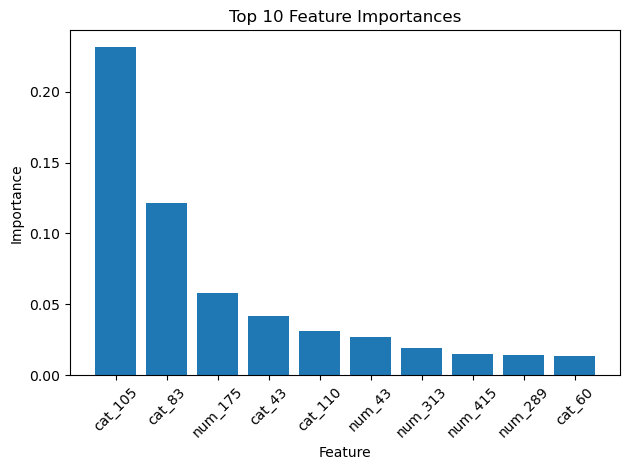

In [21]:
feature_names = df_preprocessed.columns

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Select the top 10 features
top_features_indices = sorted_indices[:10]
top_features_importances = sorted_importances[:10]

top_feature_names = [feature_names[i] for i in top_features_indices]

plt.bar(range(len(top_features_importances)), top_features_importances)
plt.xticks(range(len(top_features_importances)), top_feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


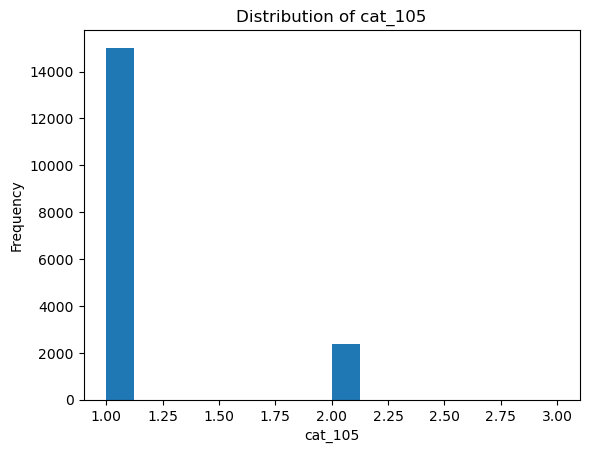

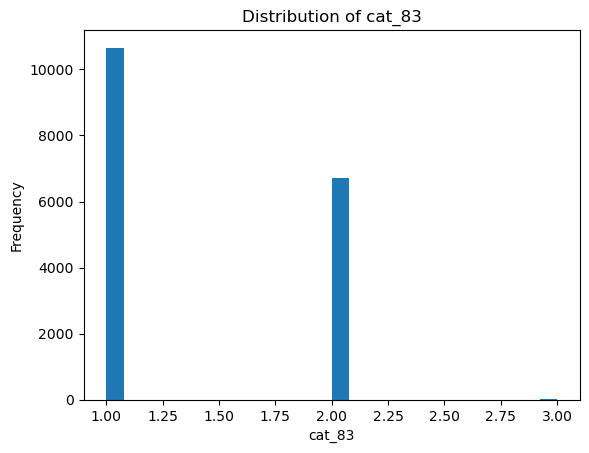

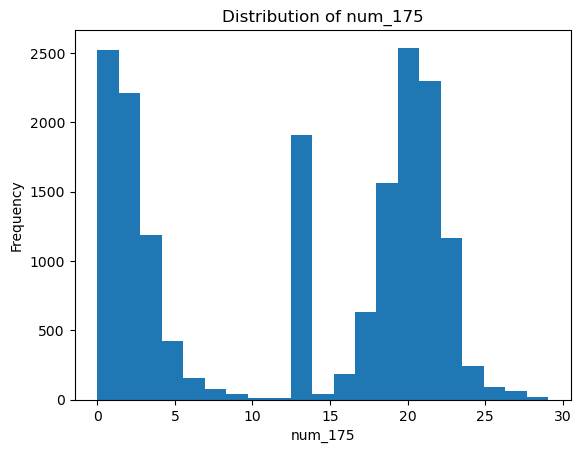

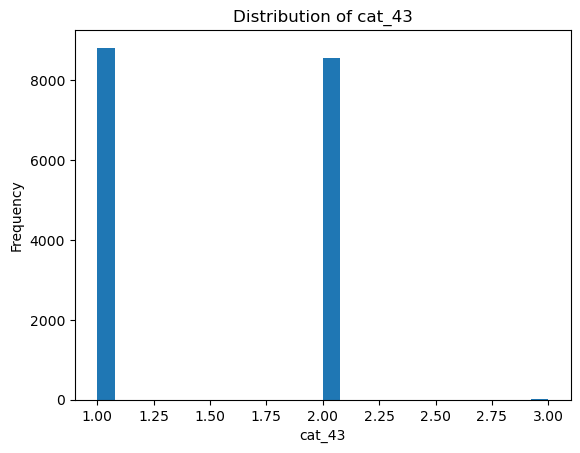

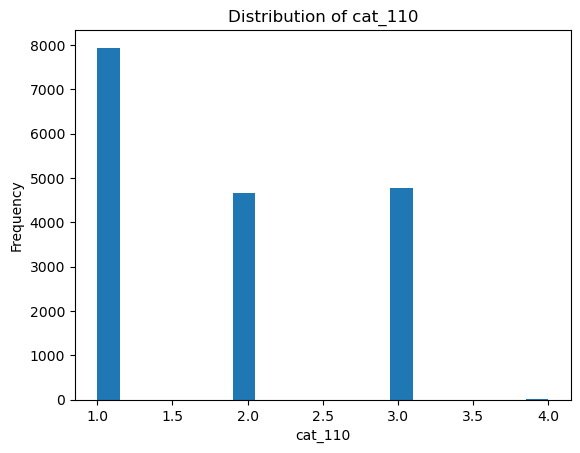

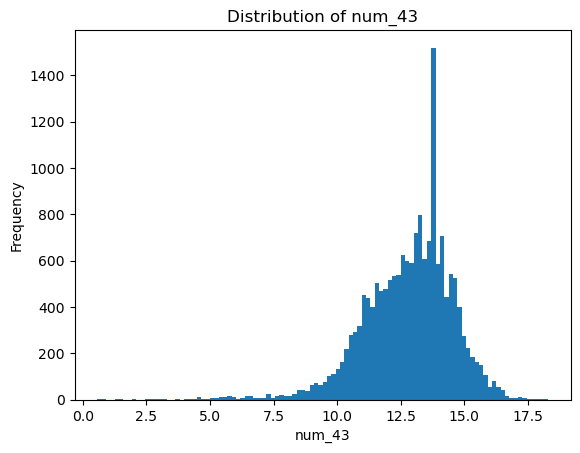

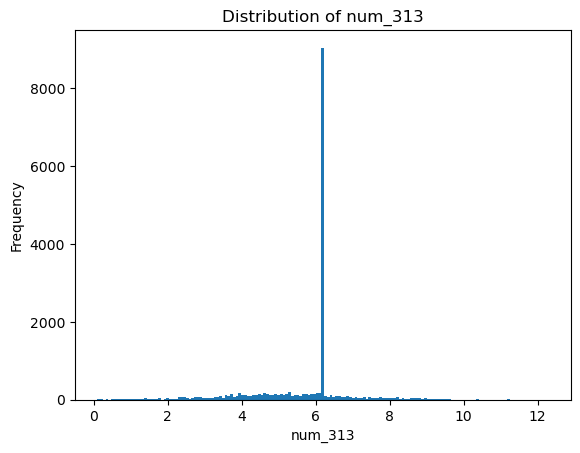

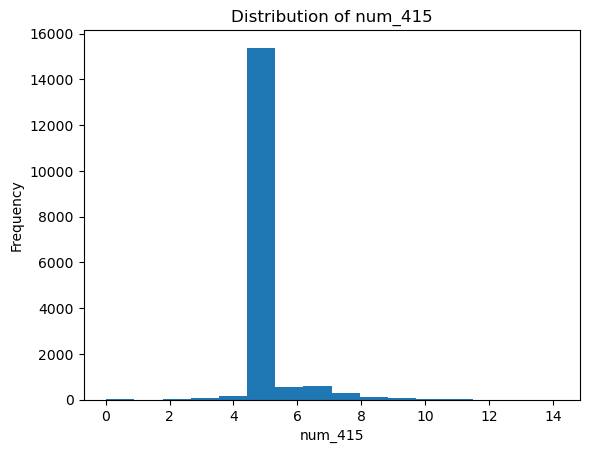

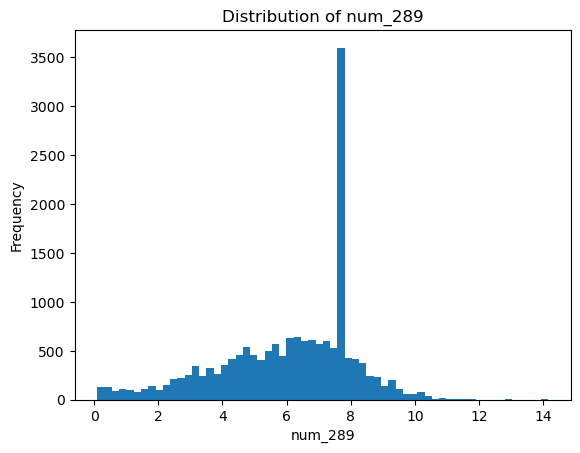

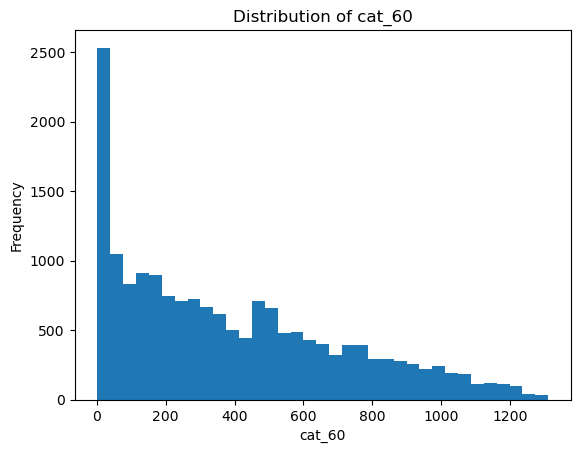

In [22]:
# Plot histograms for the top 10 features
for feature_name in top_feature_names:
    selected_feature = df_preprocessed[feature_name]
    plt.hist(selected_feature, bins='auto')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature_name}')
    plt.show()

### We still can see a lot of zero values

In [23]:
columns_with_majority_zero = []
zero_counts = {}

for column in X_train_sm.columns:
    value_counts = X_train_sm[column].value_counts()
    majority_value = value_counts.idxmax()
    majority_count = value_counts.max()

    if majority_value == 0:
        columns_with_majority_zero.append(column)
        zero_counts[column] = majority_count

print("Columns where the majority value is 0:")
print(columns_with_majority_zero)

print("Count of 0 values for each column:")
for column, count in zero_counts.items():
    print(f"{column}: {count}")

Columns where the majority value is 0:
['num_53', 'num_79', 'num_105', 'num_255', 'num_298']
Count of 0 values for each column:
num_53: 26894
num_79: 26894
num_105: 26894
num_255: 26894
num_298: 26894


## TEST

In [24]:
# or data/delay_df.csv
df_test = pd.read_csv("/kaggle/input/privat-bank-ds/delay_df.csv", sep="\t")

In [25]:
def check_matching_columns(df_train, df_test):
    """
    Checks if the columns in the train and test datasets (excluding the target column) are the same.
    This helps prevent incorrect predictions caused by inconsistent column structures.

    Args:
        df_train (pandas.DataFrame): The train dataset.
        df_test (pandas.DataFrame): The test dataset.

    Returns:
        bool: True if the columns are the same, False otherwise.
    """
    # Compare train dataset without target
    train_columns = set(df_train.columns[:-1])
    test_columns = set(df_test.columns)

    if train_columns == test_columns:
        print("The columns in the train and test datasets (excluding the target column) are the same.")
        return True
    else:
        print("The columns in the train and test datasets (excluding the target column) are different")
        return False

In [26]:
check_matching_columns(df_preprocessed, df_test)

The columns in the train and test datasets (excluding the target column) are different


False

In [27]:

df_test = df_test.drop(delete[0], axis=1)


In [28]:
df_test = df_test.drop(columns=delete[1])

In [29]:

df_test = df_test.drop(columns=delete[2])
df_test = df_test.drop(columns=["Unnamed: 0", "id"])


In [30]:
df_test = df_test.drop(columns=delete[3])

In [31]:
df_impute = impute(df_test)
df_outliers = del_outliers(df_impute)
df_skew = del_skew(df_outliers)
df_replace_zeros = replace_zeros(df_skew)

0
0


In [32]:
df_test_preprocessed = df_replace_zeros

In [33]:
check_matching_columns(df_preprocessed, df_replace_zeros)

The columns in the train and test datasets (excluding the target column) are the same.


True

### Use XGBoost for prediciton

In [34]:
predictions = xgboost.predict(df_test_preprocessed)

my_series = pd.Series(predictions)
print(my_series.value_counts())

0    6771
1      40
dtype: int64


#### Add prediction to sample dataset and save 

In [35]:
df_replace_zeros['Predictions'] = predictions

In [36]:
df_replace_zeros.to_csv('sample_delay_df.csv', index=False)